In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Connected DB CINS_SMY - conn
Connected oraDW_ANALYTICS - conn_aly


In [2]:
query11 = """WITH 
T0 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_CUST_STT_CHG_01112023),
T1 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_SCORE_01112023),
T2 AS (
    SELECT *
        FROM (SELECT T0.*, T1.SCORE, T1.RANK
        FROM T0 INNER JOIN T1 ON T0.CUSTOMER_CDE = T1.CUSTOMER_CDE
        ORDER BY SCORE DESC)),
T21 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT
    WHERE SD_TKTT = 1 AND PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')),
T3 AS (
    SELECT T21.*, T2.SCORE, T2.CUST_STT, T2.CUST_STT_LAG, T2.CUST_STT_CHG, T2.REACTIVATED
    FROM T21 
    INNER JOIN T2 ON T21.CUSTOMER_CDE = T2.CUSTOMER_CDE),
T4 AS (
    SELECT * FROM DW_ANALYTICS.DW_ORG_LOCATION_DIM),
T5 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_FULL_DIM),
T6 AS (
    SELECT * FROM DW_ANALYTICS.DW_DEPOSIT_FCT),
T7 AS (
    SELECT * FROM DW_ANALYTICS.DW_LOAN_FCT),
T8 AS (
    SELECT * FROM DW_ANALYTICS.DW_SBVCODE_DIM),
T9 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_DIM
    WHERE ACTIVE = 1),
T10 AS (
    SELECT * FROM CINS_FEATURE_STORE_REACTIVATED_01112023
    WHERE FTR_NM='CASA_DAY_SINCE_LAST_TXN_CT_36M'),
D1 AS (
    SELECT 
    T4.AREA_NAME, T5.SUB_BRANCH_CDE, T4.SUB_BRANCH_NAME, 
    T5.CUSTOMER_CDE, T5.FULL_NAME, T5.EMAIL, T5.MOBILE_PHONE, 
    T3.CUST_TYPE, T3.CUST_STATUS, T3.CUST_OPEN_DT,
    T3.TKTT, T3.TK, T3.VAY, T3.BH, T3.PAY, T3.IB, T3.MB, T3.SP_KHAC, 
    T3.LASTEST_TRANS_DT, T10.FTR_VAL AS CASA_DAY_SINCE_LAST_TXN,
    T9.DAO_CDE,
    T1.SCORE, T1.RANK, T3.REACTIVATED
    FROM T5
    INNER JOIN T3 ON T5.CUSTOMER_CDE = T3.CUSTOMER_CDE
    INNER JOIN T4 ON T5.SUB_BRANCH_CDE = T4.SUB_BRANCH_CDE
    INNER JOIN T1 ON T5.CUSTOMER_CDE = T1.CUSTOMER_CDE
    INNER JOIN T9 ON T5.CUSTOMER_CDE = T9.CUSTOMER_CDE
    INNER JOIN T10 ON T5.CUSTOMER_CDE = T10.CUSTOMER_CDE),
D2 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(ACTUAL_BAL_LCL) AS TOTAL_BAL
    FROM T1 
    LEFT JOIN T6 ON T1.CUSTOMER_CDE = T6.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T6.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'DP' AND T6.PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D3 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(OS_AMT_LCL) AS TOTAL_LOAN
    FROM T1 
    LEFT JOIN T7 ON T1.CUSTOMER_CDE = T7.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T7.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'LN' AND T7.PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D4 AS (
    SELECT 
    D1.AREA_NAME, D1.SUB_BRANCH_CDE, D1.SUB_BRANCH_NAME, 
    D1.CUSTOMER_CDE, D1.FULL_NAME, D1.EMAIL, D1.MOBILE_PHONE, 
    D1.CUST_TYPE, D1.CUST_STATUS, D1.CUST_OPEN_DT,
    D1.TKTT, D1.TK, D1.VAY, D1.BH, D1.PAY, D1.IB, D1.MB, D1.SP_KHAC, 
    NVL(D2.TOTAL_BAL, 0) AS TOTAL_BAL, 
    NVL(D3.TOTAL_LOAN, 0) AS TOTAL_LOAN,
    D1.LASTEST_TRANS_DT, 
    CASE WHEN D1.CASA_DAY_SINCE_LAST_TXN IS NULL THEN NULL ELSE ROUND(D1.CASA_DAY_SINCE_LAST_TXN / 30) END AS MONTH_TYPE,
    D1.DAO_CDE,
    D1.CASA_DAY_SINCE_LAST_TXN,
    D1.SCORE, D1.RANK, D1.REACTIVATED
    FROM D1 
    LEFT JOIN D2 ON D1.CUSTOMER_CDE = D2.CUSTOMER_CDE
    LEFT JOIN D3 ON D1.CUSTOMER_CDE = D3.CUSTOMER_CDE)
SELECT *
FROM D4
"""

In [3]:
query10 = """WITH 
T0 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_CUST_STT_CHG_01082023),
T1 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_SCORE_01082023),
T2 AS (
    SELECT *
        FROM (SELECT T0.*, T1.SCORE, T1.RANK
        FROM T0 INNER JOIN T1 ON T0.CUSTOMER_CDE = T1.CUSTOMER_CDE
        ORDER BY SCORE DESC)),
T21 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT
    WHERE SD_TKTT = 1 AND PROCESS_DT = TO_DATE('31-07-2023', 'DD-MM-YY')),
T3 AS (
    SELECT T21.*, T2.SCORE, T2.CUST_STT, T2.CUST_STT_LAG, T2.CUST_STT_CHG, T2.REACTIVATED
    FROM T21 
    INNER JOIN T2 ON T21.CUSTOMER_CDE = T2.CUSTOMER_CDE),
T4 AS (
    SELECT * FROM DW_ANALYTICS.DW_ORG_LOCATION_DIM),
T5 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_FULL_DIM),
T6 AS (
    SELECT * FROM DW_ANALYTICS.DW_DEPOSIT_FCT),
T7 AS (
    SELECT * FROM DW_ANALYTICS.DW_LOAN_FCT),
T8 AS (
    SELECT * FROM DW_ANALYTICS.DW_SBVCODE_DIM),
T9 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_DIM
    WHERE ACTIVE = 1),
T10 AS (
    SELECT * FROM CINS_FEATURE_STORE_REACTIVATED_01082023
    WHERE FTR_NM='CASA_DAY_SINCE_LAST_TXN_CT_36M'),
D1 AS (
    SELECT 
    T4.AREA_NAME, T5.SUB_BRANCH_CDE, T4.SUB_BRANCH_NAME, 
    T5.CUSTOMER_CDE, T5.FULL_NAME, T5.EMAIL, T5.MOBILE_PHONE, 
    T3.CUST_TYPE, T3.CUST_STATUS, T3.CUST_OPEN_DT,
    T3.TKTT, T3.TK, T3.VAY, T3.BH, T3.PAY, T3.IB, T3.MB, T3.SP_KHAC, 
    T3.LASTEST_TRANS_DT, T10.FTR_VAL AS CASA_DAY_SINCE_LAST_TXN,
    T9.DAO_CDE,
    T1.SCORE, T1.RANK, T3.REACTIVATED
    FROM T5
    INNER JOIN T3 ON T5.CUSTOMER_CDE = T3.CUSTOMER_CDE
    INNER JOIN T4 ON T5.SUB_BRANCH_CDE = T4.SUB_BRANCH_CDE
    INNER JOIN T1 ON T5.CUSTOMER_CDE = T1.CUSTOMER_CDE
    INNER JOIN T9 ON T5.CUSTOMER_CDE = T9.CUSTOMER_CDE
    INNER JOIN T10 ON T5.CUSTOMER_CDE = T10.CUSTOMER_CDE),
D2 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(ACTUAL_BAL_LCL) AS TOTAL_BAL
    FROM T1 
    LEFT JOIN T6 ON T1.CUSTOMER_CDE = T6.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T6.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'DP' AND T6.PROCESS_DT = TO_DATE('31-07-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D3 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(OS_AMT_LCL) AS TOTAL_LOAN
    FROM T1 
    LEFT JOIN T7 ON T1.CUSTOMER_CDE = T7.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T7.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'LN' AND T7.PROCESS_DT = TO_DATE('31-07-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D4 AS (
    SELECT 
    D1.AREA_NAME, D1.SUB_BRANCH_CDE, D1.SUB_BRANCH_NAME, 
    D1.CUSTOMER_CDE, D1.FULL_NAME, D1.EMAIL, D1.MOBILE_PHONE, 
    D1.CUST_TYPE, D1.CUST_STATUS, D1.CUST_OPEN_DT,
    D1.TKTT, D1.TK, D1.VAY, D1.BH, D1.PAY, D1.IB, D1.MB, D1.SP_KHAC, 
    NVL(D2.TOTAL_BAL, 0) AS TOTAL_BAL, 
    NVL(D3.TOTAL_LOAN, 0) AS TOTAL_LOAN,
    D1.LASTEST_TRANS_DT, 
    CASE WHEN D1.CASA_DAY_SINCE_LAST_TXN IS NULL THEN NULL ELSE ROUND(D1.CASA_DAY_SINCE_LAST_TXN / 30) END AS MONTH_TYPE,
    D1.DAO_CDE,
    D1.CASA_DAY_SINCE_LAST_TXN,
    D1.SCORE, D1.RANK, D1.REACTIVATED
    FROM D1 
    LEFT JOIN D2 ON D1.CUSTOMER_CDE = D2.CUSTOMER_CDE
    LEFT JOIN D3 ON D1.CUSTOMER_CDE = D3.CUSTOMER_CDE)
SELECT *
FROM D4
"""

In [4]:
portfolio_10 = download_or_reload('data/PORTFOLIO_08', query10, update=False)

Len 9009053


In [5]:
portfolio_11 = download_or_reload('data/PORTFOLIO_11', query11, update=False)

Len 9268694


In [6]:
portfolio_10['CASA_DAY_SINCE_LAST_TXN'] = portfolio_10['CASA_DAY_SINCE_LAST_TXN'].astype(int)
portfolio_11['CASA_DAY_SINCE_LAST_TXN'] = portfolio_11['CASA_DAY_SINCE_LAST_TXN'].astype(int)

In [7]:
portfolio_10

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
0,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,18243579,LE THM5AVWPUMTV,ABCxxxxxxx@SACOMBANK.COM,098xxxxxx24,CN,HOAT DONG,2023-07-17,...,0.0,196098.0,0,2023-08-01,0,30196,1,0.986707,0,NaN
1,KV MIEN BAC,VN0011916,PGD YEN DINH - CNTHA,18237674,LUU S3B3X1YSVIR,ABCxxxxxxx@SACOMBANK.COM,036xxxxxx92,CN,HOAT DONG,2023-07-13,...,0.0,186733.0,0,2023-08-01,0,55807,1,0.986707,2,NaN
2,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,18233183,PHAM GZZQ3HZJVY,ABCxxxxxxx@SACOMBANK.COM,098xxxxxx10,CN,HOAT DONG,2023-07-12,...,0.0,183765.0,0,2023-08-01,0,30196,1,0.986707,1,NaN
3,KV MIEN BAC,VN0011793,PGD SAO DO,18226092,HA THEI57WDZ3SW,ABCxxxxxxx@SACOMBANK.COM,039xxxxxx85,CN,HOAT DONG,2023-07-10,...,1.0,68504.0,1000000000,2023-08-01,0,57469,1,0.982608,3,NaN
4,KV MIEN BAC,VN0011791,CHI NHANH HAI DUONG,18263219,NONG YQTK7S9E91,ABCxxxxxxx@SACOMBANK.COM,086xxxxxx07,CN,HOAT DONG,2023-07-24,...,0.0,771903.0,0,2023-08-01,0,15836,1,0.980524,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9009048,KV NAM TRUNG BO - TAY NGUYEN,VN0012344,CHI NHANH DAK NONG,6519275,LE THI8O7NHLT43,ABCxxxxxxx@SACOMBANK.COM,037xxxxxx65,CN,NGU DONG,2015-04-20,...,0.0,1550.0,0,2019-01-30,37,29656,1095,0.000110,8742167,0.0
9009049,KV NAM TRUNG BO - TAY NGUYEN,VN0011583,CHI NHANH NINH HOA,9150705,LE TH1LRK2QK74I,ABCxxxxxxx@SACOMBANK.COM,077xxxxxx49,CN,NGU DONG,2016-06-29,...,0.0,1550.0,0,2019-02-22,37,22695,1095,0.000108,8742169,0.0
9009050,KV NAM TRUNG BO - TAY NGUYEN,VN0012961,CHI NHANH GIA LAI,9127104,TRAN N07UE8MV4R,ABCxxxxxxx@SACOMBANK.COM,083xxxxxx75,CN,NGU DONG,2016-06-23,...,0.0,1550.0,0,2019-01-30,37,44539,1095,0.000108,8742168,0.0
9009051,KV NAM TRUNG BO - TAY NGUYEN,VN0013064,PGD DAK BLA,9859844,NGUYE6KLUM8R86R,XUAxxxxxxx@GMAIL.COM,097xxxxxx65,CN,NGU DONG,2016-11-24,...,0.0,1550.0,0,2019-01-30,37,23333,1095,0.000108,8742170,0.0


In [8]:
portfolio_10['REACTIVATED'].value_counts(dropna=False)

NaN    7989145
0.0     998616
1.0      21292
Name: REACTIVATED, dtype: int64

In [9]:
portfolio_11['REACTIVATED'].value_counts(dropna=False)

NaN    8198034
0.0     995451
1.0      75209
Name: REACTIVATED, dtype: int64

In [10]:
portfolio_10 = portfolio_10[portfolio_10['CUST_STATUS'].isin(['NGU DONG', 'DONG BANG'])]
portfolio_10.shape

(1115117, 27)

In [11]:
portfolio_11 = portfolio_11[portfolio_11['CUST_STATUS'].isin(['NGU DONG', 'DONG BANG'])]
portfolio_11.shape

(1170289, 27)

# PORTFOLIO 10

In [12]:
# d1 include d2
d1 = portfolio_10.sort_values(by='SCORE', ascending=False)
d1

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
19,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18279855,PHAM T6F6MRCR66,ABCxxxxxxx@SACOMBANK.COM,091xxxxxx01,CN,NGU DONG,2023-07-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,20,1.0
21,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18279869,GIANG1SJR3F9R53,ABCxxxxxxx@SACOMBANK.COM,082xxxxxx33,CN,NGU DONG,2023-07-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,19,1.0
20,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18279862,NGUYECY8CPPCSNW,ABCxxxxxxx@SACOMBANK.COM,090xxxxxx13,CN,NGU DONG,2023-07-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,21,1.0
22,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18279840,NGUYEDNY4I8ZEG5,ABCxxxxxxx@SACOMBANK.COM,037xxxxxx26,CN,NGU DONG,2023-07-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973779,22,1.0
24,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18279843,MAC TO4C7CJ271L,ABCxxxxxxx@SACOMBANK.COM,079xxxxxx08,CN,NGU DONG,2023-07-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973779,24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9009048,KV NAM TRUNG BO - TAY NGUYEN,VN0012344,CHI NHANH DAK NONG,6519275,LE THI8O7NHLT43,ABCxxxxxxx@SACOMBANK.COM,037xxxxxx65,CN,NGU DONG,2015-04-20,...,0.0,1550.0,0,2019-01-30,37,29656,1095,0.000110,8742167,0.0
9009049,KV NAM TRUNG BO - TAY NGUYEN,VN0011583,CHI NHANH NINH HOA,9150705,LE TH1LRK2QK74I,ABCxxxxxxx@SACOMBANK.COM,077xxxxxx49,CN,NGU DONG,2016-06-29,...,0.0,1550.0,0,2019-02-22,37,22695,1095,0.000108,8742169,0.0
9009050,KV NAM TRUNG BO - TAY NGUYEN,VN0012961,CHI NHANH GIA LAI,9127104,TRAN N07UE8MV4R,ABCxxxxxxx@SACOMBANK.COM,083xxxxxx75,CN,NGU DONG,2016-06-23,...,0.0,1550.0,0,2019-01-30,37,44539,1095,0.000108,8742168,0.0
9009051,KV NAM TRUNG BO - TAY NGUYEN,VN0013064,PGD DAK BLA,9859844,NGUYE6KLUM8R86R,XUAxxxxxxx@GMAIL.COM,097xxxxxx65,CN,NGU DONG,2016-11-24,...,0.0,1550.0,0,2019-01-30,37,23333,1095,0.000108,8742170,0.0


In [13]:
d1['REACTIVATED'].value_counts()

0.0    998616
1.0     21292
Name: REACTIVATED, dtype: int64

## AUC

In [14]:
from sklearn import metrics
tmp = d1[['REACTIVATED', 'SCORE']].dropna()
auc = metrics.roc_auc_score(tmp['REACTIVATED'], tmp['SCORE'])
gini = 2 * auc - 1
auc, gini

(0.8303488099763774, 0.6606976199527548)

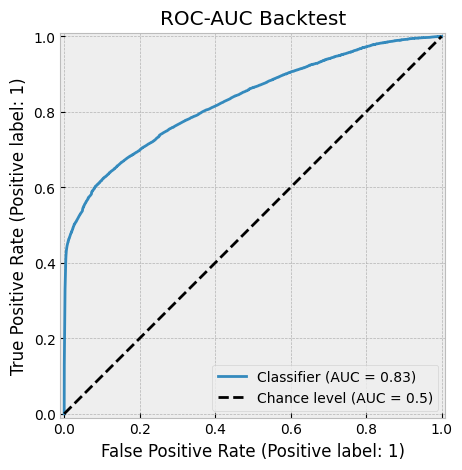

In [15]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))
metrics.RocCurveDisplay.from_predictions(tmp['REACTIVATED'], tmp['SCORE'], plot_chance_level=True, ax=axs)
axs.set_title('ROC-AUC Backtest')
plt.grid = True
plt.show()

## BINNING

In [16]:
num_buckets = 10

In [17]:
d1['BUCKET'], bins = pd.qcut(d1['SCORE'], num_buckets, labels=range(10, 0, -1), retbins=True)
d1['BUCKET'] = d1['BUCKET'].astype(int)

In [18]:
d1['BUCKET'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [19]:
d1['BUCKET'].value_counts().sort_index()

1     111512
2     111512
3     111510
4     111513
5     111496
6     111513
7     111524
8     111461
9     111563
10    111513
Name: BUCKET, dtype: int64

In [20]:
bins

array([8.82387758e-05, 1.90751592e-03, 4.02583787e-03, 6.50475966e-03,
       9.64544713e-03, 1.22485999e-02, 1.40007302e-02, 1.61908064e-02,
       2.13943630e-02, 3.32757190e-02, 9.73862827e-01])

### CAP

In [21]:
tmp = d1[['REACTIVATED', 'BUCKET']].dropna()
tmp['REACTIVATED'] = tmp['REACTIVATED'].astype(int)
tmp = tmp.groupby('BUCKET')['REACTIVATED'].value_counts().to_frame('num_cust').reset_index().pivot(index='BUCKET', columns='REACTIVATED', values='num_cust')
tmp['TOTAL_LEAD'] = tmp[0] + tmp[1]
tmp

REACTIVATED,0,1,TOTAL_LEAD
BUCKET,,,
1,78280,12670,90950
2,93526,1829,95355
3,98912,1453,100365
4,104894,1186,106080
5,105753,1069,106822
6,102871,952,103823
7,100897,760,101657
8,102152,710,102862
9,104037,457,104494


In [22]:
total_reactivated = tmp[1].sum()
total_leads = tmp['TOTAL_LEAD'].sum()
total_leads, total_reactivated

(1019908, 21292)

In [23]:
tmp['perc_REACTIVATED'] = tmp[1] / total_reactivated * 100
tmp['cumsum_REACTIVATED'] = tmp[1].cumsum()
tmp['perc_cumsum_REACTIVATED'] = tmp['cumsum_REACTIVATED'] / total_reactivated * 100
tmp['lift'] = tmp['perc_cumsum_REACTIVATED'] / (tmp['TOTAL_LEAD'].cumsum() / total_leads)  / 100

In [24]:
tmp

REACTIVATED,0,1,TOTAL_LEAD,perc_REACTIVATED,cumsum_REACTIVATED,perc_cumsum_REACTIVATED,lift
BUCKET,,,,,,,
1,78280,12670,90950,59.505918,12670,59.505918,6.672959
2,93526,1829,95355,8.590081,14499,68.095998,3.727847
3,98912,1453,100365,6.824159,15952,74.920158,2.665492
4,104894,1186,106080,5.570167,17138,80.490325,2.090203
5,105753,1069,106822,5.020665,18207,85.510990,1.745761
6,102871,952,103823,4.471163,19159,89.982153,1.520953
7,100897,760,101657,3.569416,19919,93.551569,1.353290
8,102152,710,102862,3.334586,20629,96.886154,1.223088
9,104037,457,104494,2.146346,21086,99.032500,1.107005


## PORTFOLIO CHARACTERISTIC - OCT

In [25]:
# let 
d11 = d1[d1['REACTIVATED']==1] # reactive only
d12 = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)] # bucket 1 - no-reactived

d11['REACTIVATED'] = d11['REACTIVATED'].astype(int)
d12['REACTIVATED'] = d12['REACTIVATED'].astype(int)

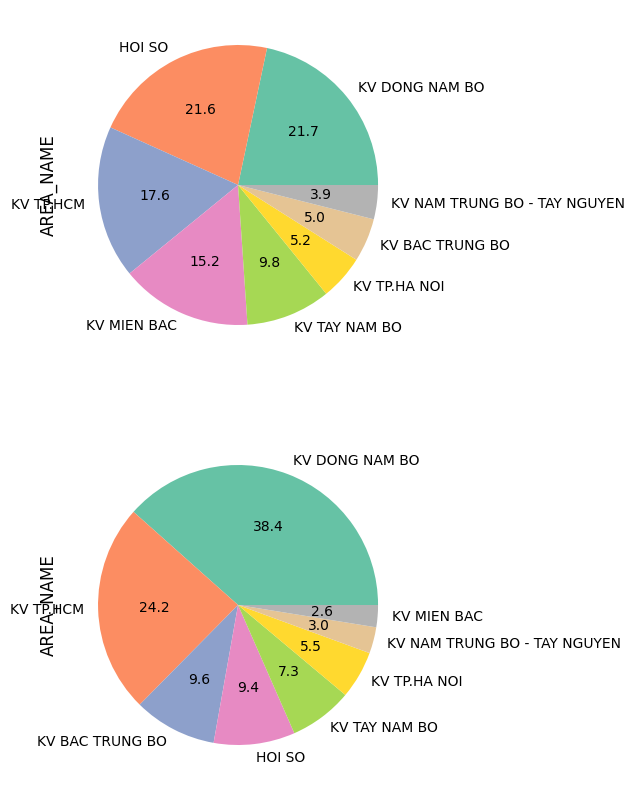

In [26]:
f, axs = plt.subplots(2, 1, figsize=(10,10))
d11['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[0])
d12['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[1])
# d2[d2['BUCKET']==1]['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[2])
plt.show()

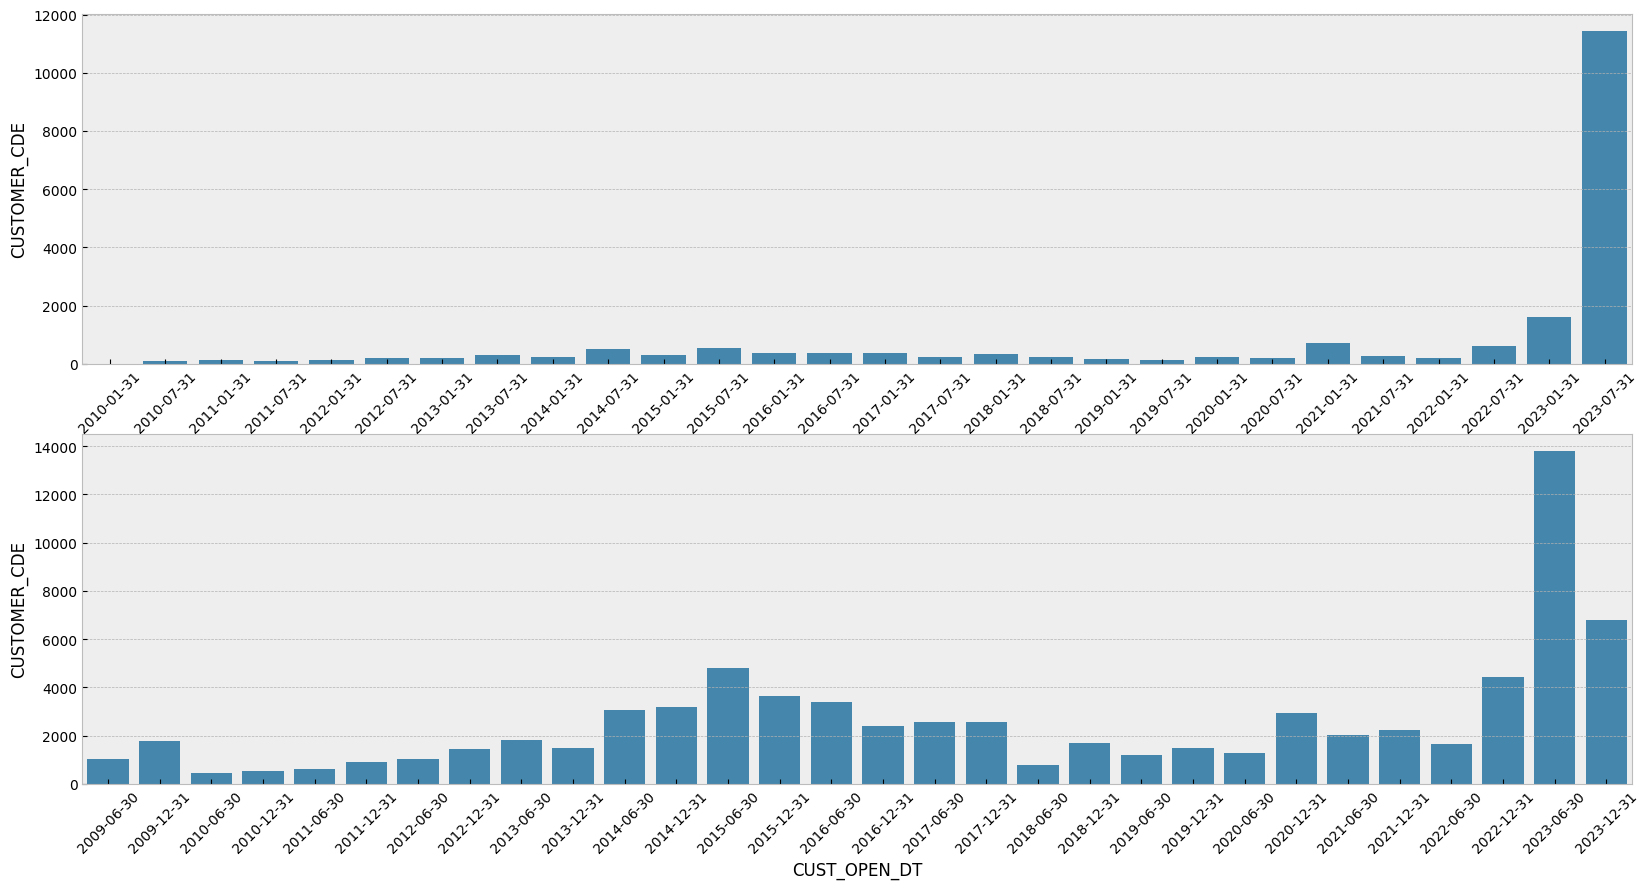

In [35]:
tmp = d11[d11['CUST_OPEN_DT']>='2010-01-01']
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()
fig, axs = plt.subplots(2,1, figsize=(20, 10))
sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE', ax=axs[0])

tmp = d12
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()
sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE', ax=axs[1])

axs[0].tick_params(axis='x', rotation=45)
axs[1].tick_params(axis='x', rotation=45)
plt.show()

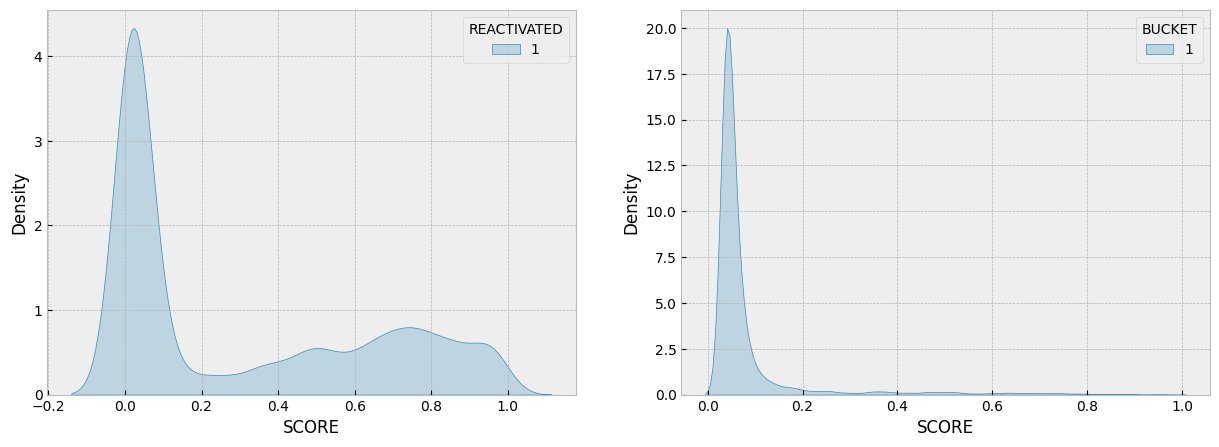

In [28]:
f, axs = plt.subplots(1,2,figsize=(15,5))
sns.kdeplot(d11, x='SCORE', hue='REACTIVATED', fill=True, common_norm=False, ax=axs[0])
sns.kdeplot(d12, x='SCORE', hue='BUCKET', fill=True, common_norm=False, ax=axs[1])
# sns.kdeplot(d2, x='SCORE', hue='BUCKET', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[2])
plt.show()

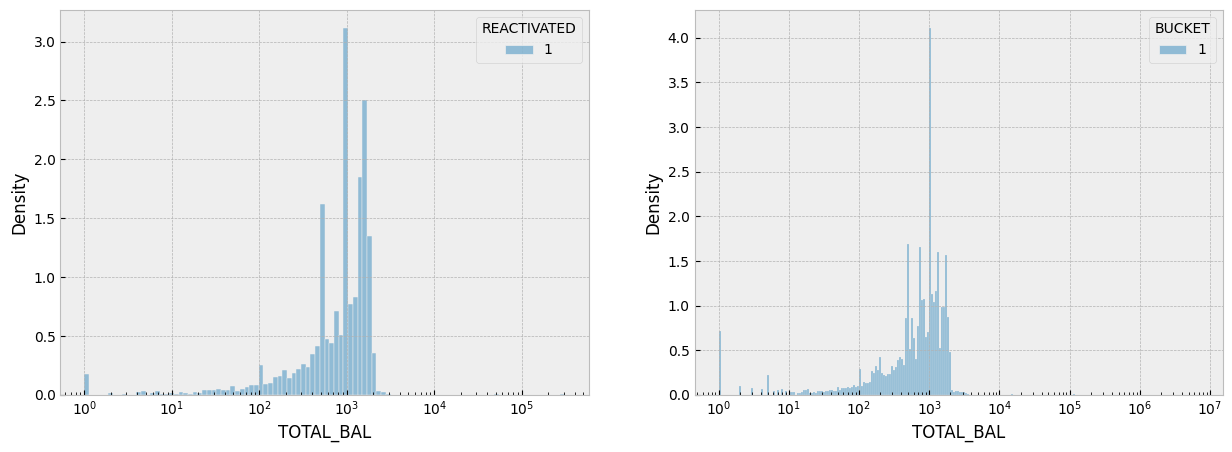

In [29]:
f, axs = plt.subplots(1,2,figsize=(15,5))
sns.histplot(d11, x='TOTAL_BAL', hue='REACTIVATED', log_scale=True, stat='density', common_norm=False,ax=axs[0])
sns.histplot(d12, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,ax=axs[1])
# sns.histplot(d2, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,palette='crest',ax=axs[2])
plt.show()

In [30]:
d11['TOTAL_LOAN'].sum(), d12['TOTAL_LOAN'].sum()

(0, 0)

In [31]:
# f, axs = plt.subplots(1,2,figsize=(15,5))
# tmp = d1[d1['REACTIVATED']==1]
# tmp = tmp[tmp['TOTAL_LOAN']>0]
# print(len(tmp))
# # sns.kdeplot(tmp, x='TOTAL_LOAN', hue='REACTIVATED', log_scale=False, ax=axs[0])

# tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
# tmp = tmp[tmp['TOTAL_LOAN']>0]
# print(len(tmp))
# # sns.kdeplot(tmp, x='TOTAL_LOAN', hue='BUCKET', log_scale=False, ax=axs[1])
# # sns.histplot(d2, x='TOTAL_LOAN', hue='BUCKET', log_scale=True, stat='density',palette='crest', alpha=0.3, ax=axs[2])
# # axs[0].set_xlim([0, 1e10])
# # axs[1].set_xlim([0, 1e10])
# plt.show()

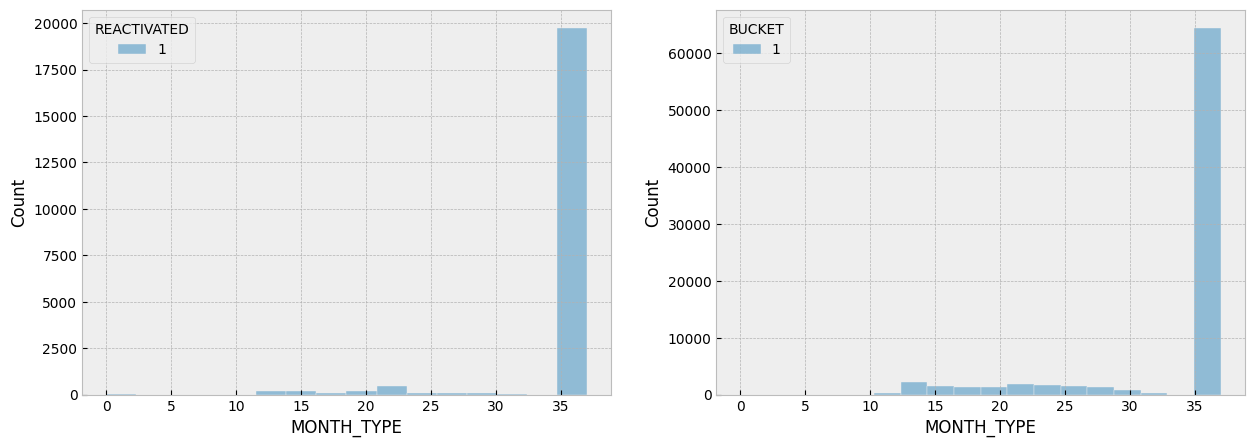

In [32]:
f, axs = plt.subplots(1,2,figsize=(15,5))
sns.histplot(d11, x='MONTH_TYPE', hue='REACTIVATED', fill=True, stat='count',common_norm=True, linewidth=0.3,ax=axs[0])
sns.histplot(d12, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, linewidth=0.3,ax=axs[1])
# sns.histplot(d2, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,palette='crest', ax=axs[2])
plt.show()

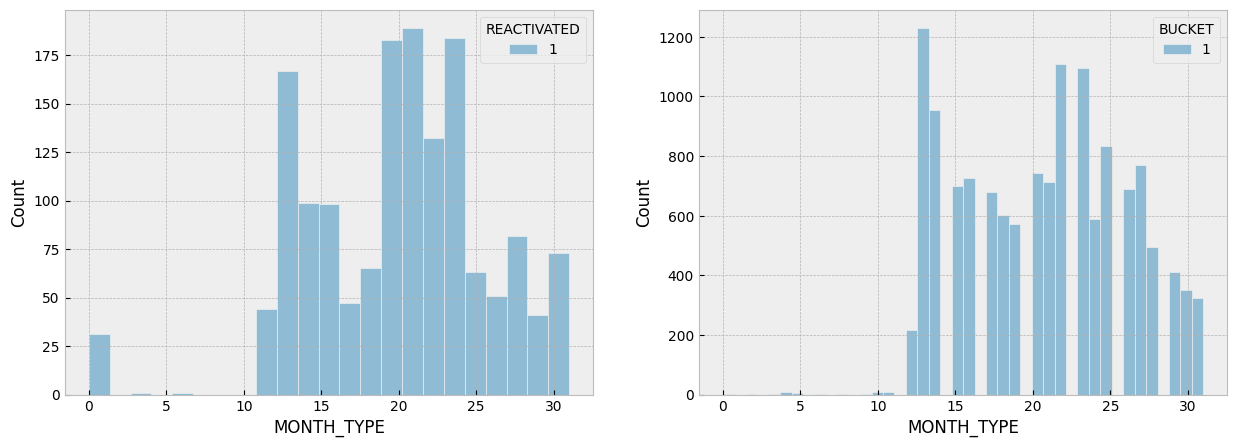

In [33]:
f, axs = plt.subplots(1,2,figsize=(15,5))
tmp = d11
tmp = tmp[tmp['MONTH_TYPE']<37]
sns.histplot(tmp,x='MONTH_TYPE', hue='REACTIVATED',common_norm=False,ax=axs[0])
# tmp = d1[(d1['BUCKET']>7) & (d1['MONTH_TYPE']<37) & (d1['MONTH_TYPE']>1)].copy()
tmp = d12
tmp = tmp[tmp['MONTH_TYPE']<37]
sns.histplot(tmp,x='MONTH_TYPE', hue='BUCKET',common_norm=False, ax=axs[1])
# sns.kdeplot(d2[(d2['MONTH_TYPE']<37) & (d2['MONTH_TYPE']>1) & (d2['BUCKET']>7)],x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[2])
plt.show()

# MAPPING BUCKET - NOV

In [36]:
# exclude reactivated in port-10
d2 = portfolio_11[~portfolio_11['CUSTOMER_CDE'].isin(d11['CUSTOMER_CDE'])].sort_values(by='SCORE', ascending=False)
d2

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
24,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535516,PHAM SYLPXHJQSC,ABCxxxxxxx@SACOMBANK.COM,034xxxxxx07,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,30,1.0
30,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535525,HO A ILQ32PDT5K,ABCxxxxxxx@SACOMBANK.COM,085xxxxxx10,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,32,1.0
33,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535555,NGUYEYEAXTDY2G6,ABCxxxxxxx@SACOMBANK.COM,070xxxxxx44,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,33,1.0
32,KV MIEN BAC,VN0011796,PGD THANH MIEN,18531927,TRAN D0270QI10B,ABCxxxxxxx@SACOMBANK.COM,096xxxxxx50,CN,NGU DONG,2023-10-30,...,0.0,0.0,0,NaT,37,71282,1095,0.973863,28,1.0
31,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535560,DO DUZ0LOBQRZB1,ABCxxxxxxx@SACOMBANK.COM,056xxxxxx60,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268688,KV MIEN BAC,VN0011915,PGD NGHI SON,2344333,KH VATXF4UF6XWN,,xxxxxx,CN,NGU DONG,2011-07-11,...,0.0,0.0,0,NaT,37,17474,1095,0.000166,8981945,0.0
9268689,KV MIEN BAC,VN0013142,PGD MONG CAI,7058387,LE MAP4PXZBWSO2,ABCxxxxxxx@SACOMBANK.COM,xxxxxx,CN,DONG BANG,2015-07-21,...,0.0,0.0,0,NaT,37,27213,1095,0.000155,8981946,0.0
9268690,KV NAM TRUNG BO - TAY NGUYEN,VN0011581,CHI NHANH KHANH HOA,6140218,THAI WX5D39K6NQ,ABCxxxxxxx@SACOMBANK.COM,091xxxxxx76,CN,DONG BANG,2015-03-05,...,0.0,5681.0,2666620000,2023-10-31,37,23344,1095,0.000155,8981947,NaN
9268691,KV MIEN BAC,VN0011526,PGD VAN GIANG-CN HYN,10007902,KH VAIFTUDMB6ZI,,xxxxxx,CN,NGU DONG,2016-12-28,...,0.0,0.0,0,NaT,37,1,1095,0.000123,8981948,0.0


In [37]:
d2['CUST_STATUS'].value_counts()

NGU DONG     927831
DONG BANG    241577
Name: CUST_STATUS, dtype: int64

In [38]:
d2['REACTIVATED'].value_counts()

0.0    995443
1.0     75208
Name: REACTIVATED, dtype: int64

In [39]:
criteria = [
    d2['SCORE'].between(bins[i], bins[i+1], inclusive='right') for i in range(num_buckets)
]
values=range(10, 0, -1)

In [40]:
d2['BUCKET'] = np.select(criteria, values, 0)

In [41]:
d2['BUCKET'].value_counts().sort_index()

1     126383
2     125579
3     107764
4     105805
5     104554
6     150604
7     126199
8     111846
9     107031
10    103643
Name: BUCKET, dtype: int64

## BUCKET MAPPING

In [42]:
tmp = d2[['REACTIVATED', 'BUCKET']].dropna()
tmp['REACTIVATED'] = tmp['REACTIVATED'].astype(int)
tmp = tmp.groupby('BUCKET')['REACTIVATED'].value_counts().to_frame('num_cust').reset_index().pivot(index='BUCKET', columns='REACTIVATED', values='num_cust')
tmp['TOTAL_LEAD'] = tmp[0] + tmp[1]
tmp

REACTIVATED,0,1,TOTAL_LEAD
BUCKET,,,
1,83225,20902,104127
2,98846,9208,108054
3,89161,7023,96184
4,94646,5560,100206
5,94760,4947,99707
6,135464,6889,142353
7,109463,6640,116103
8,98000,5518,103518
9,95856,4484,100340


In [43]:
total_reactivated = tmp[1].sum()
total_leads = tmp['TOTAL_LEAD'].sum()
total_leads, total_reactivated

(1070651, 75208)

In [44]:
tmp['perc_REACTIVATED'] = tmp[1] / total_reactivated * 100
tmp['cumsum_REACTIVATED'] = tmp[1].cumsum()
tmp['perc_cumsum_REACTIVATED'] = tmp['cumsum_REACTIVATED'] / total_reactivated * 100
tmp['lift'] = tmp['perc_cumsum_REACTIVATED'] / (tmp['TOTAL_LEAD'].cumsum() / total_leads)  / 100

In [45]:
tmp

REACTIVATED,0,1,TOTAL_LEAD,perc_REACTIVATED,cumsum_REACTIVATED,perc_cumsum_REACTIVATED,lift
BUCKET,,,,,,,
1,83225,20902,104127,27.792256,20902,27.792256,2.857646
2,98846,9208,108054,12.243378,30110,40.035635,2.020171
3,89161,7023,96184,9.338102,37133,49.373737,1.714269
4,94646,5560,100206,7.392831,42693,56.766567,1.487555
5,94760,4947,99707,6.577758,47640,63.344325,1.334303
6,135464,6889,142353,9.159930,54529,72.504255,1.193100
7,109463,6640,116103,8.828848,61169,81.333103,1.135718
8,98000,5518,103518,7.336985,66687,88.670088,1.090888
9,95856,4484,100340,5.962132,71171,94.632220,1.043879


## PORTFOLIO-MAPPING CHARACTERISTIC

In [46]:
d2.groupby('BUCKET')[['TOTAL_LOAN', 'TOTAL_BAL']].describe()

TOTAL_LOAN                                                  \
            count          mean           std  min  25%  50%  75%   
BUCKET                                                              
1        126383.0  2.139526e+07  5.568620e+08  0.0  0.0  0.0  0.0   
2        125579.0  1.548701e+07  1.859978e+09  0.0  0.0  0.0  0.0   
3        107764.0  5.425356e+06  4.720708e+08  0.0  0.0  0.0  0.0   
4        105805.0  1.645755e+06  1.127661e+08  0.0  0.0  0.0  0.0   
5        104554.0  1.338170e+06  1.960537e+08  0.0  0.0  0.0  0.0   
6        150604.0  1.397083e+06  1.098393e+08  0.0  0.0  0.0  0.0   
7        126199.0  2.486519e+06  1.656764e+08  0.0  0.0  0.0  0.0   
8        111846.0  1.478649e+06  8.603684e+07  0.0  0.0  0.0  0.0   
9        107031.0  1.144237e+06  8.922100e+07  0.0  0.0  0.0  0.0   
10       103643.0  1.120683e+05  1.438251e+07  0.0  0.0  0.0  0.0   

                     TOTAL_BAL                                               \
                 max     count          mean           std  min  25%    50%   
BUCKET                                                                        
1       8.308332e+10  126383.0  1.268479e+07  4.307387e+08  0.0  0.0    0.0   
2       6.227860e+11  125579.0  1.208980e+07  1.244817e+09  0.0  0.0   22.0   
3       1.403765e+11  107764.0  4.620667e+06  1.855830e+08  0.0  0.0    0.0   
4       2.301597e+10  105805.0  1.923111e+06  1.171895e+08  0.0  0.0    0.0   
5       6.100000e+10  104554.0  1.173743e+06  8.228810e+07  0.0  0.0    0.0   
6       2.602595e+10  150604.0  2.386818e+06  5.228068e+08  0.0  0.0    0.0   
7       3.300000e+10  126199.0  1.415346e+06  7.653511e+07  0.0  0.0   35.0   
8       1.360000e+10  111846.0  2.298999e+06  3.139594e+08  0.0  0.0  150.0   
9       1.400000e+10  107031.0  5.950984e+05  6.865329e+07  0.0  0.0  300.0   
10      3.310000e+09  103643.0  2.917530e+05  1.893626e+07  0.0  0.0    0.0   

                              
           75%           max  
BUCKET                        
1       1049.0  7.083378e+10  
2       1162.5  4.130812e+11  
3       1000.0  4.503259e+10  
4          0.0  3.222418e+10  
5          0.0  1.652815e+10  
6        288.0  2.001141e+11  
7       1032.0  1.554521e+10  
8       1245.0  9.334924e+10  
9       1325.0  2.153585e+10  
10       952.5  3.000016e+09

In [47]:
d21 = d2[d2['BUCKET']==1]

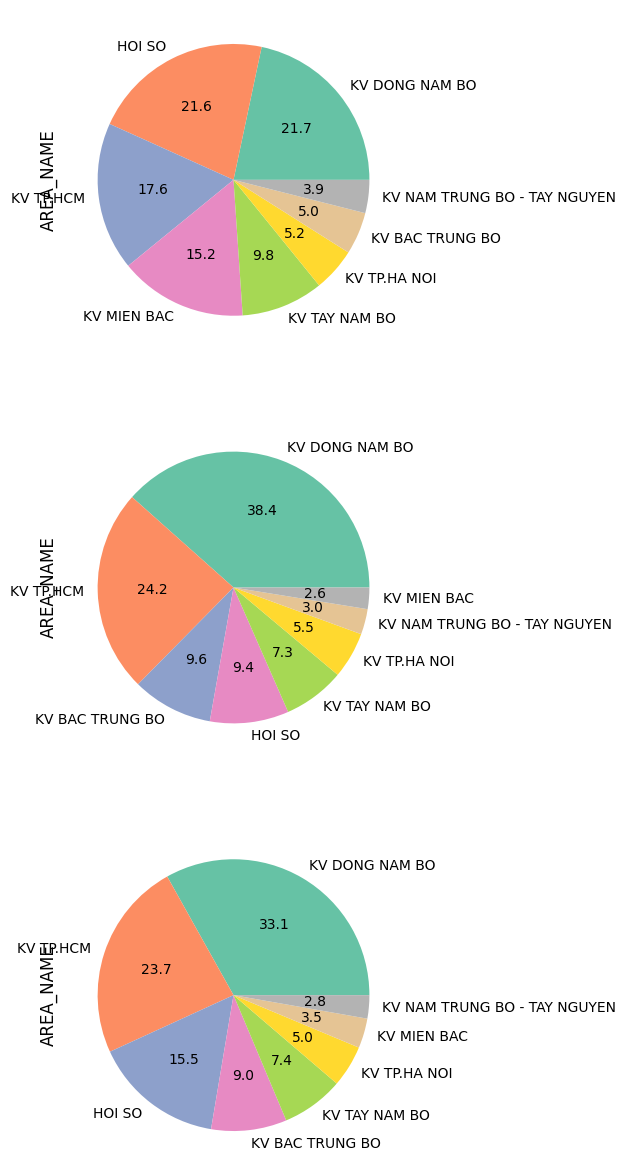

In [48]:
f, axs = plt.subplots(3, 1, figsize=(10,15))
d11['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[0])
d12['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[1])
d21['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[2])
plt.show()

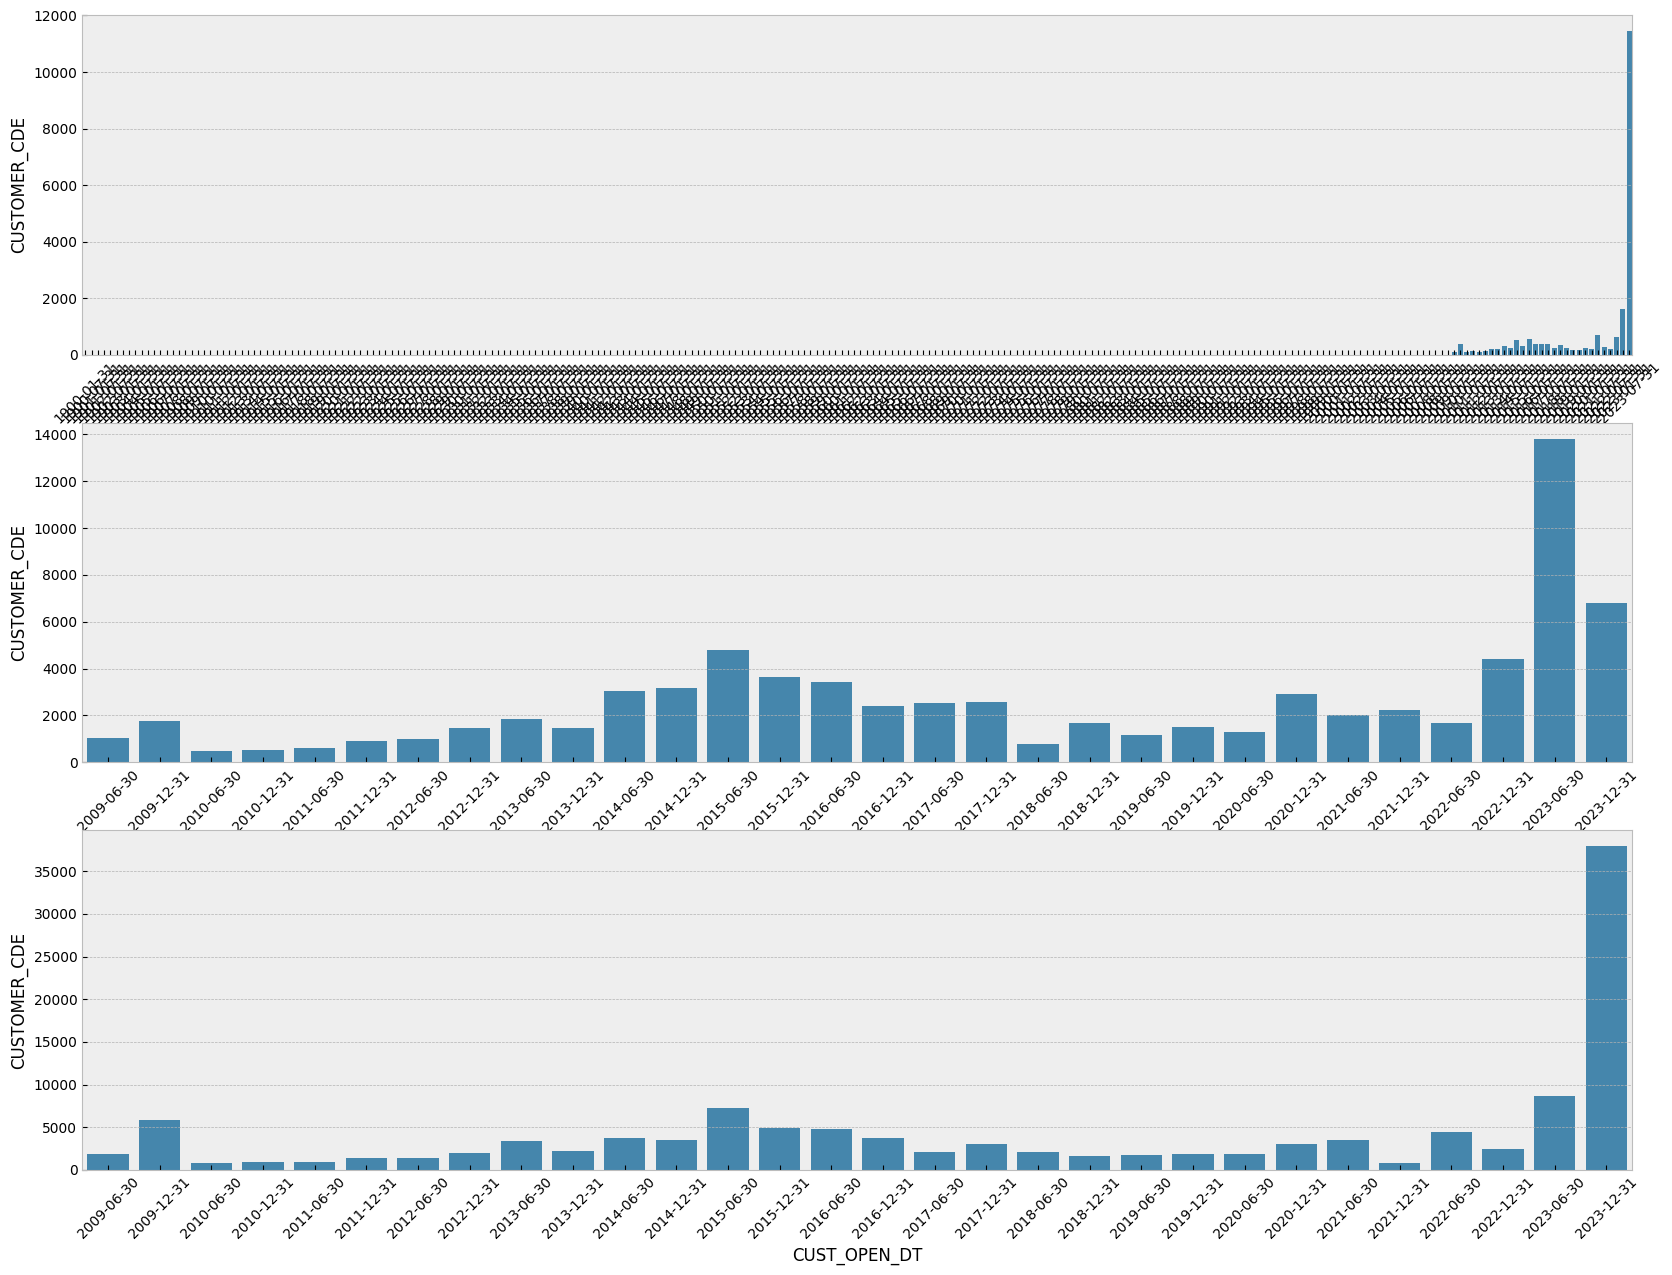

In [49]:
fig, axs = plt.subplots(3,1, figsize=(20, 15))

tmp = d11
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()

sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE', ax=axs[0])

tmp = d12
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()
sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE', ax=axs[1])

tmp = d21
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()
sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE', ax=axs[2])

axs[0].tick_params(axis='x', rotation=45)
axs[1].tick_params(axis='x', rotation=45)
axs[2].tick_params(axis='x', rotation=45)
plt.show()

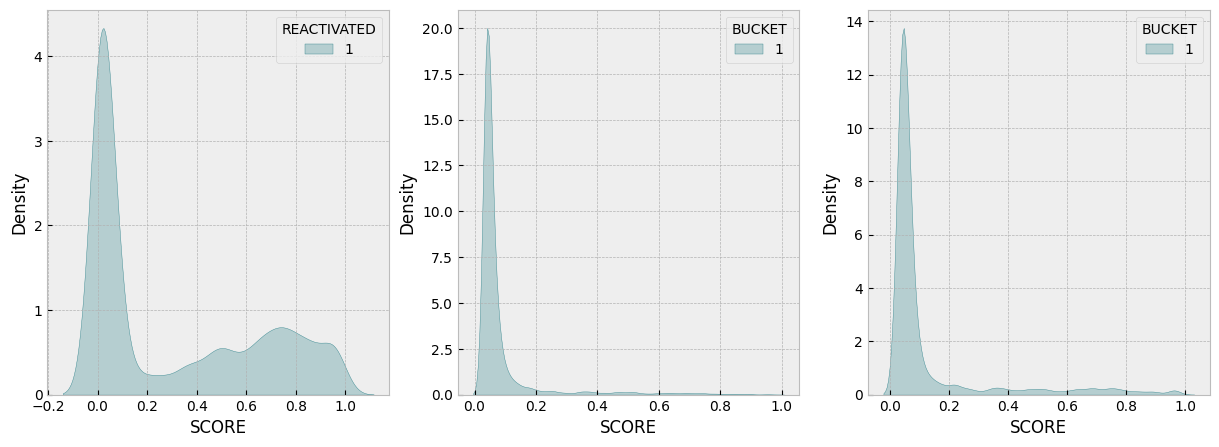

In [50]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.kdeplot(d11, x='SCORE', hue='REACTIVATED', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[0])
sns.kdeplot(d12, x='SCORE', hue='BUCKET', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[1])
sns.kdeplot(d21, x='SCORE', hue='BUCKET', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[2])
plt.show()

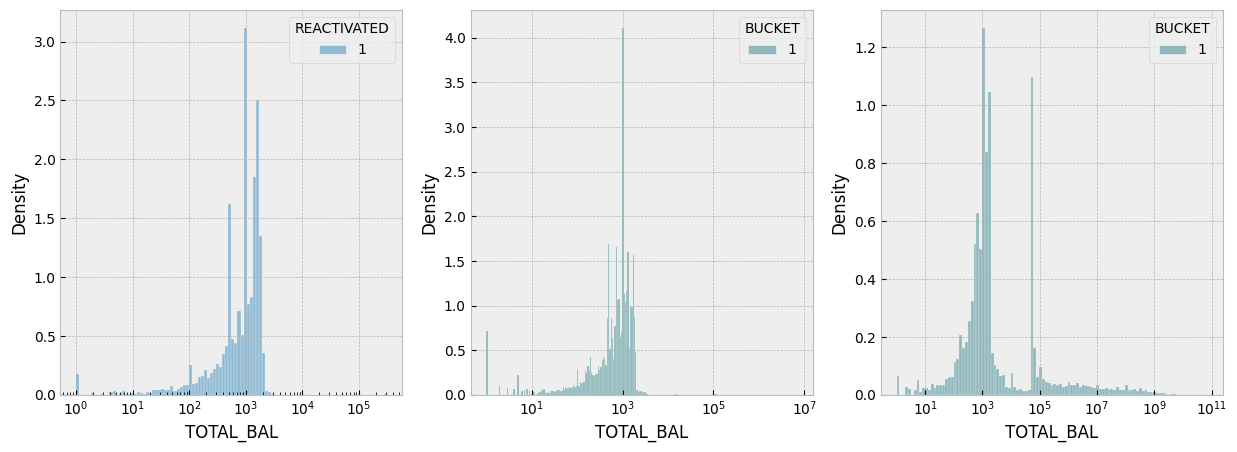

In [51]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(d11, x='TOTAL_BAL', hue='REACTIVATED', log_scale=True, stat='density', common_norm=False,ax=axs[0])
sns.histplot(d12, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,palette='crest',ax=axs[1])
sns.histplot(d21, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,palette='crest',ax=axs[2])
plt.show()

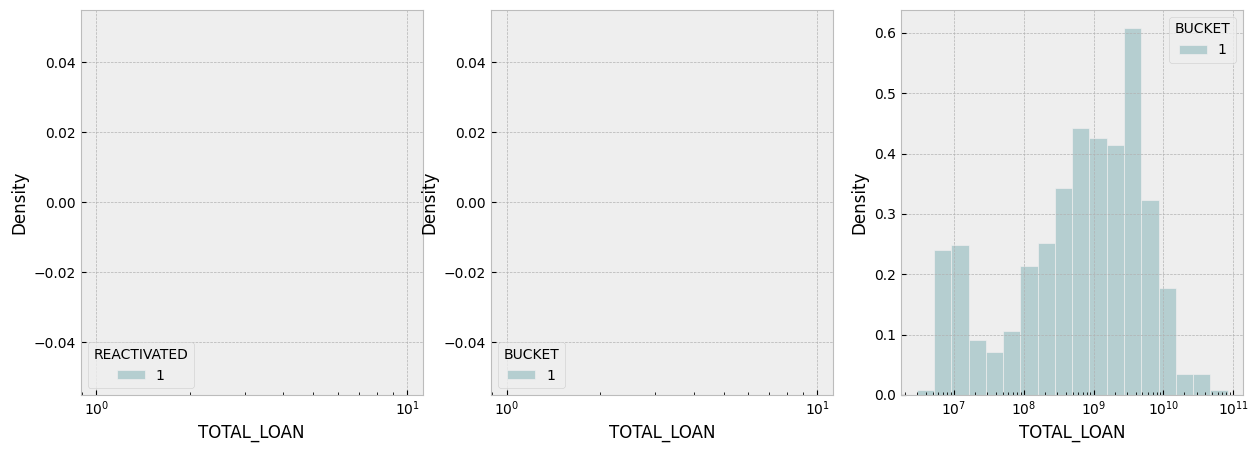

In [52]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(d11, x='TOTAL_LOAN', hue='REACTIVATED', log_scale=True, stat='density', palette='crest', alpha=0.3, ax=axs[0])
sns.histplot(d12, x='TOTAL_LOAN', hue='BUCKET', log_scale=True, stat='density', palette='crest', alpha=0.3, ax=axs[1])
sns.histplot(d21, x='TOTAL_LOAN', hue='BUCKET', log_scale=True, stat='density',palette='crest', alpha=0.3, ax=axs[2])
# axs[0].set_xlim([0, 1e10])
# axs[1].set_xlim([0, 1e10])
plt.show()

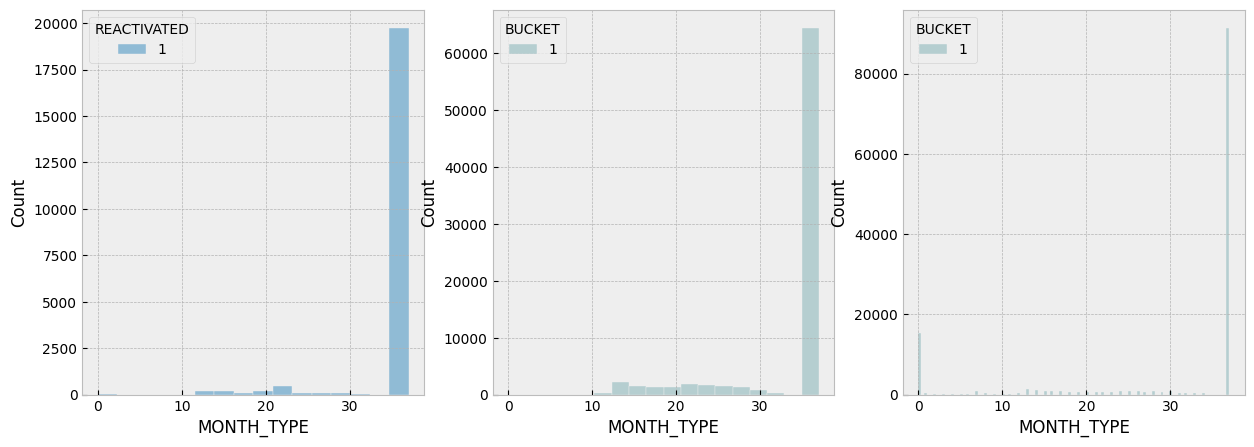

In [53]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(d11, x='MONTH_TYPE', hue='REACTIVATED', fill=True, stat='count',common_norm=True, linewidth=0.3,ax=axs[0])
sns.histplot(d12, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,palette='crest', ax=axs[1])
sns.histplot(d21, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,palette='crest', ax=axs[2])
plt.show()


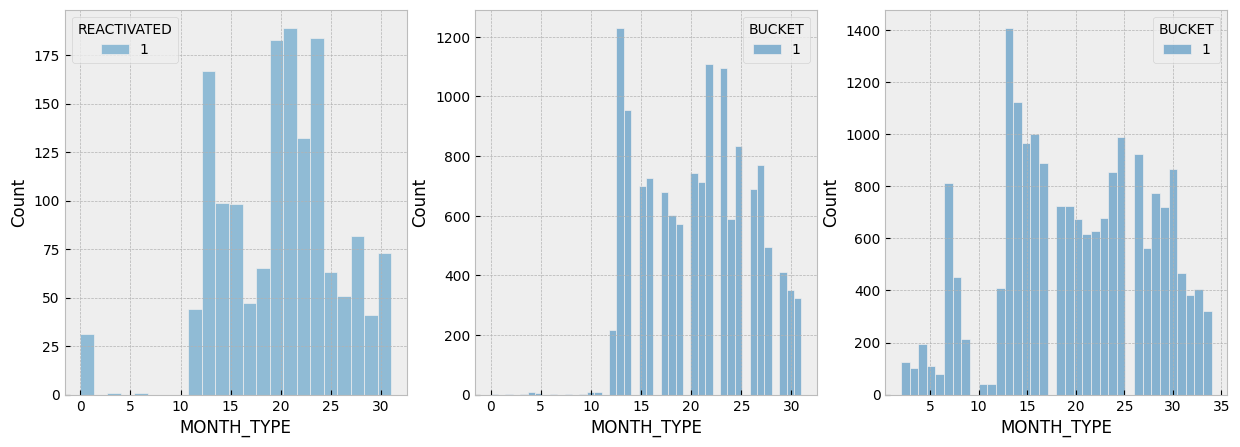

In [54]:
f, axs = plt.subplots(1,3,figsize=(15,5))
# d1['MONTH_TYPE'] = d1['MONTH_TYPE'].astype(int)
# d2['MONTH_TYPE'] = d2['MONTH_TYPE'].astype(int)
tmp = d11[d11['MONTH_TYPE']<37]
sns.histplot(tmp,x='MONTH_TYPE', hue='REACTIVATED',common_norm=False,ax=axs[0])

tmp = d12[d12['MONTH_TYPE']<37]
sns.histplot(tmp,x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[1])

tmp = d21[(d21['MONTH_TYPE']<37) & (d21['MONTH_TYPE']>1)]
sns.histplot(tmp,x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[2])
plt.show()